# Discriminative vs Generative Models

#### Load Libraries

In [20]:
library(mvtnorm) # for multivariate Gaussian data
library(ggplot2) # for plots
library(reshape2) 

#### I. Load dataset

In [21]:
# read data
train_data <- read.csv('Data//1E_train.csv')
test_data <- read.csv('Data//1E_test.csv')

D <- 2

train.len <- dim(train_data)[1]
test.len <- dim(test_data)[1]

# separate labels and features from data set
train.index <- sample(1:train.len,train.len)
train.data <- train_data[train.index,  1:D]
train.label <- train_data[train.index, 'y']
test.data <- test_data[, 1:D]
test.label <- test_data[, 'y']

### Bayesian Classifier

In [22]:
# Bayesian classifier
BC.classfier  <- function(train, test) {
    
    train.len <- nrow(train)
    # obtain train and test with labels
    train.data <- train[, 1:D]
    train.label <- train[, 'y']
    
    test.data  <- test[,1:D]
    test.label  <- test[,"y"]
    
    # Class probabilities:
    p0.hat <- sum(train.label==1)/nrow(train.data) # number of samples in class 0 divided by the training data size
    p1.hat <- sum(train.label==-1)/nrow(train.data) # number of samples in class 1 divided by the training data size
    
    # calculate mean
    mu0.hat <- colMeans(train.data[train.label==c0,])
    mu1.hat <- colMeans(train.data[train.label==c1,])

    # calculate class covariance matrices
    sigma0.hat <- var(train.data[train.label==c0,])
    sigma1.hat <- var(train.data[train.label==c1,])
    
    # shared covariance matrix
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 
    
    # calculate posteriors
    posterior0 <- p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma.hat)

    # calculate predictions
    train.predict <- ifelse(posterior0 > posterior1, c0, c1)
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), 1, -1)

    # test error
    test.error  <- sum(test.label!=test.predict)/nrow(test.data)*100
    
    return(test.error)
}

###  Auxiliary Functions

In [23]:
# function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

# Sigmoid function 
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

### Logistic Regression Classifier

In [24]:
LR.classifer  <- function(train, test){
     # get train and test dataset with labels   
    train.data <- train[, 1:D]
    train.label <- train[, 'y']
    
    test.data  <- test[,1:D]
    test.label  <- test[,"y"]
    
    # Initializations
    train.len <- nrow(train.data) # length of the train data
    tau.max <- 10*train.len # maximum number of iterations
    eta <- 0.01 # learning rate
    epsilon <- 0.01 # a threshold on the cost (to terminate the process)
    tau <- 1# iteration counter
    terminate <- FALSE 

    ## Just a few name/type conversion to make the rest of the code easy to follow
    X <- as.matrix(train.data)       # rename just for conviniance
    T <- ifelse(train.label==c0,0,1) # rename just for conviniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
    
    W[1,] <- runif(ncol(W))# initial weight

    Y <- sigmoid(W[1,],X) # project data using the sigmoid function (just for convenient) 

    costs <- data.frame('tau'=1:tau.max)# to be used to trace the cost in each iteration
    costs[1, 'cost'] <- cost(W[1,],X,T, c0)
    
    # we use SGD to learn the weight vector
    while(!terminate){
        
        # check termination criteria:
        terminate <- tau >= tau.max | cost(W[tau,],X,T, c0)<=epsilon
        
        # shuffle data:
        train.index <- sample(1:train.len, train.len, replace = FALSE)
        X <- X[train.index,]
        T <- T[train.index]
        
        # for each datapoint:
        for (i in 1:train.len){
            # check termination criteria:
            if (tau >= tau.max | cost(W[tau,],X,T, c0) <=epsilon) {terminate<-TRUE;break}
            Y <- sigmoid(W[tau,],X)
            
            # Update the weights
            W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))
            
            # record the cost:
            costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, c0)
            
            # update the counter:
            tau <- tau + 1
            
            # decrease learning rate:
            eta = eta * 0.999
        }
    }
    
    # remove the NaN tail of the vector
    costs <- costs[1:tau, ] 
    
    # the final result is:
    w <- W[tau,]
    
    # return error rate
    test.error  <- sum(predict(w,test.data,c0,c1)!=test.label)/nrow(test.data)*100
    
    return(test.error)
}

**Using the first 5 data points from the training set, train a BC and a LR model,increase the size of training set (5 data points at a time), retrain the models and calculate their training and testing errors until all training data points are used.**

In [25]:
# class labels
c0 <- 1; c1 <- -1 

train.len <- nrow(train_data) # size of training dataset 
sequence <- seq(5,train.len,5) # sequence of train
count <- length(sequence)  # number of expts

# test error dataframe 
test.error <- data.frame(matrix(ncol = 0, nrow = 0))

train.index <- sample(1:train.len, train.len, replace = FALSE)
train <- train_data[train.index,]

# Set errors
for (size in sequence){
    
    # calculate errors for both classifier
    bc.error  <- BC.classfier(train[1:size,], test_data)
    lg.error  <- LR.classifer(train[1:size,], test_data)
    
    # set testing errors
    test.error[size/5, 'Bayesian Classifier'] <- bc.error
    test.error[size/5, 'Logistic Regression'] <- lg.error
    
}

In [26]:
# return error
test.error <- cbind(data.frame("Dataset_Size"=sequence), test.error)

In [27]:
# unpivot view of errors per batch
errors.m  <- melt(test.error, id="Dataset_Size")
head(errors.m)

Dataset_Size,variable,value
5,Bayesian Classifier,24.8
10,Bayesian Classifier,1.8
15,Bayesian Classifier,1.8
20,Bayesian Classifier,1.6
25,Bayesian Classifier,2.0
30,Bayesian Classifier,2.0


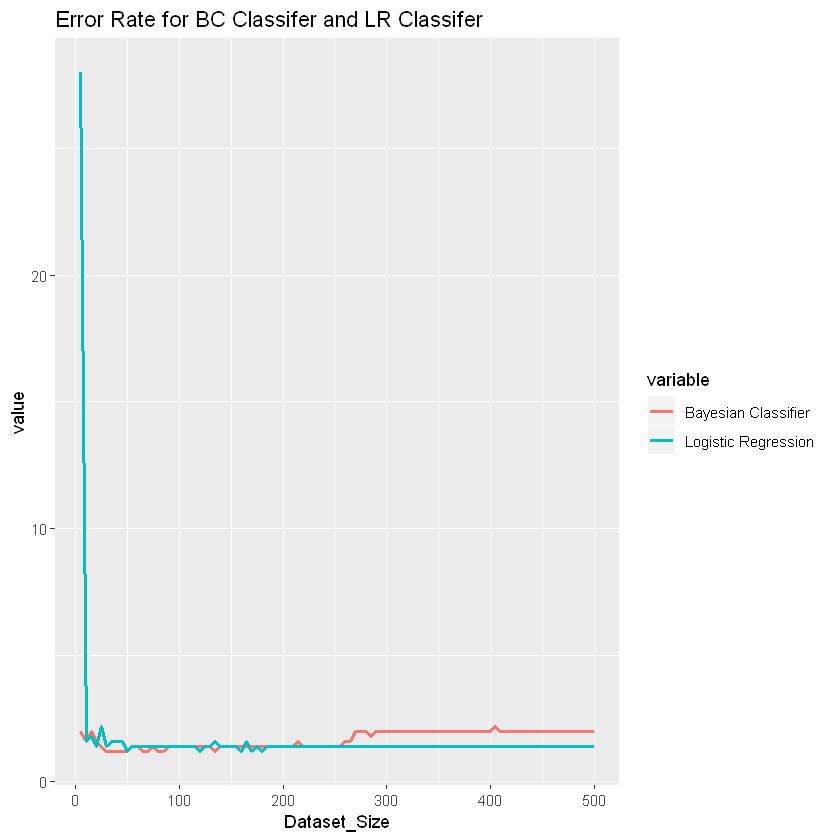

In [47]:
# error plots 
ggplot(errors.m, aes(x=Dataset_Size, y=value, color=variable)) + 
    geom_line(size=1) + 
    labs(title = "Error Rate for BC Classifer and LR Classifer")

a. What does happen for each classifier when the number of training data points is increased?

For logistic regression, When the number of training data increases, the testing error decreases and then remains almost constant after the size of training dataset is large enough. While for Bayesian Classifier, the testing error decreases with increase in size of training data, however, after some value of training dataset size, the error increases. Hence, for larger values of training dataset size, we see increased error.

b. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?

When training dataset is small we can see that bayesian classifier gives less testing error so Bayesian CLassifier is preferred, while for larger size of training data, Logistic regression is preffered.
 
c. Justify your observations in previous questions (III.a & III.b) by providing some speculations and possible reasons.

The Bayesian Classifier assumes conditional independence for every feature, so classifier expects features to be independent. For less amount of training data, the condition of independence might hold True with the help of priors which results in less error, however, when more training data is used, it is less probable for model to maintain the condition of independece (As in reality features seems dependent on each other **-0.64 correlation**). Also, Generative models assume the p(x|y) follows some particular distribution which may not be true in reality. This model has more parameters to learn and its complexity increases with increase in data size, hence, we see increase in testing error after some value of N(size).

On the other hand, Logistic regression learns the probability of a data point belonging to a particular class, which improves with increase in training data size, as . Logistic regresssion being discriminative model, doesn't make any assumption about the data (unlike Bayesian Classifier). Hence, these models generalize well on testing data if it is trained on sufficient number of training data, and we can see this from the above plot (less testing error on larger training dataset). 

In [54]:
cor(train_data['x2'], train_data['x1'])

,x1
x2,-0.6453937


In [59]:
table(train_data['y'])


 -1   1 
170 330 